In [76]:
#Installing the library containing some segmentation models
!pip install segmentation-models-pytorch

## 加载常用库

In [77]:
import numpy as np
import pandas as pd
import os

!pip install torchviz
%matplotlib inline
import cv2
import random
import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from PIL import Image
import torch.nn as nn
from torchviz import make_dot
from torch.utils.data import DataLoader
import torch.optim as optim

#Importing the library into the notebook
import segmentation_models_pytorch as seg_models
from dotenv import load_dotenv

load_dotenv()
output_folder_path = './output/city6_models'
os.makedirs(output_folder_path ,exist_ok=True)

Python-dotenv could not parse statement starting at line 15
Python-dotenv could not parse statement starting at line 18
Python-dotenv could not parse statement starting at line 20
Python-dotenv could not parse statement starting at line 22
Python-dotenv could not parse statement starting at line 24


## 可视化样本

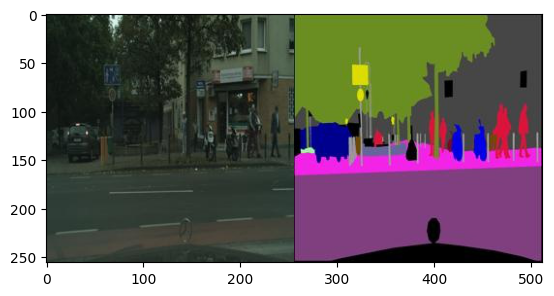

In [78]:
DATASET = os.getenv('CITY_SCAPES_DATASET')
folder_path= DATASET
TrainFolder = os.path.join(folder_path+'train')
TestFolder = os.path.join(folder_path+'val')
train_images = TrainFolder
val_images = TestFolder

train_files = os.listdir(train_images)
val_files = os.listdir(val_images)

# Print any image of your choice from the training set
s_no = 20

img = Image.open(os.path.join(train_images, train_files[s_no])).convert("RGB")

plt.imshow(img)
plt.show()

## 数据集加载

In [79]:
class data_load(object):
    def __init__(self, images_dir, batch_size, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(data_load, self).__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.target_size = target_size
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.step_number = 0
        self.total_steps = int(len(self.filenames) // self.batch_size)
        
    def generate_batch(self):
        start = self.step_number * self.batch_size
        stop = (self.step_number + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]
        
        images_batch = [cv2.imread(filename) for filename in filenames_batch]
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])
        
        # To separate images and their labels
        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch])
        
        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        images_batch /= self.rescale
        images_batch = np.moveaxis(images_batch, 1, 0)
        
        return torch.Tensor(images_batch)
    
    def __next__(self):
        if self.step_number > self.total_steps:
            self.step_number = 0
        images, masks = self.generate_batch()
        self.step_number += 1
        return images, masks
    
    def __len__(self):
        return self.total_steps

## 模型库

将要使用的模型的名称及其实例存储在字典中。

In [80]:
names = ["PSPNet", "UNet", "Unet++", "FPN", "DeepLab_V3", "DeepLab_V3+"]
models_dict = {
    "PSPNet": seg_models.PSPNet(classes=3),
    "UNet": seg_models.Unet(classes=3),
    "Unet++": seg_models.UnetPlusPlus(classes=3),
    "FPN": seg_models.FPN(classes=3),
    "DeepLab V3": seg_models.DeepLabV3(classes=3),
    "DeepLab V3+": seg_models.DeepLabV3Plus(classes=3),
}

Exception ignored in: <function tqdm.__del__ at 0x000001B14F0BBC40>
Traceback (most recent call last):
  File "c:\Users\ADMIN\anaconda3\envs\CLASS_WORK\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\ADMIN\anaconda3\envs\CLASS_WORK\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [81]:
def dice(pred, label):
    pred = (pred > 0).float()
    return 2. * (pred*label).sum() / (pred+label).sum()

## 训练函数

In [82]:
def training( model, epochs ,batch_size ,optimizer ,criterion,logs,history):
 
    train_generator = data_load(images_dir = TrainFolder, batch_size = batch_size, rescale = 255.0)
    test_generator = data_load(images_dir = TestFolder, batch_size = batch_size, rescale = 255.0)
    
    device = torch.device('cpu')
    model.to(device)
    
    main_pbar = tqdm(range(epochs))
    main_pbar.set_description('common progress ')
    
    for epoch in main_pbar:
        running_params = dict(train_loss = [], 
                               train_dice = [], 
                               test_loss = [], 
                               test_dice = [])
        train_pbar = tqdm(range(len(train_generator)))
        
        # # 计算训练的损失，并优化模型
        for step in train_pbar:
         
            train_imgs, train_masks = next(train_generator)
            train_imgs, train_masks = train_imgs.to(device), train_masks.to(device)
            
            optimizer.zero_grad()
            
            train_predictions = model(train_imgs)

            train_loss = criterion(train_predictions, train_masks)
            train_loss.backward()
                
            train_dice = dice(pred = train_predictions, label = train_masks)
            optimizer.step()
            
            # 计算测试的损失，并优化模型
            with torch.no_grad():
                test_images, test_masks = next(test_generator)
                test_images, test_masks = test_images.to(device), test_masks.to(device)
            
                test_predictions = model(test_images)
    
                test_loss = criterion(test_predictions, test_masks)
        
                test_dice = dice(pred = test_predictions, label = test_masks)
                
            
            current_metrics = dict(train_loss = [train_loss.item(), ], 
                                   train_dice = [train_dice.item(), ], 
                                   test_loss = [test_loss.item(),], 
                                   test_dice = [test_dice.item(),])
            
            running_params.update(current_metrics)
            
            mean_metrics = dict(zip(running_params.keys(), [(sum(tensor) / (step + 1)) for tensor in running_params.values()]))
    
            train_pbar.set_postfix(mean_metrics)
        
        temp = [train_loss.item(), train_dice.item(), test_loss.item(), test_dice.item()]
        logs.append(temp)
        history.update(running_params)
        best_loss = max(history['test_loss'])
        best_loss_index =  history['test_loss'].index(best_loss)
        current_loss_index = history['test_loss'].index(test_loss.item())
        if abs(current_loss_index - best_loss_index) >= 5:
            for param_group in optim.param_groups:
                if param_group['lr'] * 0.1 > 1e-6:
                    print('reduce learning rate to', {param_group['lr'] * 0.1})
                    param_group['lr'] *= 0.1


## 训练并保存权重

In [83]:
histories = []   
MODELS_FOLDER = os.getenv('MODEL_FOLDER_PATH')
six_model_of_city = os.path.join(MODELS_FOLDER+'city6_models')
os.makedirs(six_model_of_city ,exist_ok=True)
model_folder_path=six_model_of_city

for model_name, model_instance in models_dict.items():
    name = model_name
    model_name = model_instance
    model_name.to("cpu")
    x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
    x = x.to("cpu")
    outputs_x = model_name(x)
    make_dot(outputs_x, params=dict(list(model_name.named_parameters())))
    
    # 实例化优化器
    optimizer = torch.optim.Adam(params = model_name.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)

    criterion = torch.nn.BCEWithLogitsLoss()
    
    history = dict(train_loss = [], 
                   train_dice = [], 
                   test_loss = [], 
                   test_dice = [])
    
    logs = []
    
    # 训练模型
    training(model = model_name, epochs = 1, batch_size = 32 , optimizer= optimizer,criterion=criterion ,logs=logs,history=history)
    
    histories.append(logs)
    
    # 将每个模型的模型权重保存在工作目录中
   
    weights_path = os.path.join(model_folder_path, name + '_weights.pth')
    logs_path = os.path.join(model_folder_path, name + '_logs')
    torch.save(model_name.state_dict(), weights_path)

common progress :   0%|          | 0/1 [00:01<?, ?it/s]


AttributeError: module 'torch.cpu' has no attribute 'empty_cache'

## 评估每个模型

In [ ]:
def show(model_name, num_cols):
    generator = data_load(images_dir = val_images, 
                           batch_size = 8, 
                           rescale = 255.0)
    result = []
    for iteration in range(num_cols):
        images, masks = next(generator)
        images_1 = images.to("cpu")
        
        prediction = torch.sigmoid(model_name(images_1))
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        masks = np.moveaxis(masks.numpy(), 1, -1)
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        outputs = np.hstack([images, masks, prediction])
        result.append(outputs)
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)

# PSPNet

In [ ]:
name = "PSPNet"
model_name = models_dict["PSPNet"]
model_name.load_state_dict(torch.load(os.path.join(model_folder_path, name + '_weights.pth')))
model_name.eval()
show(model_name, num_cols = 2)

# UNet

In [ ]:
name = "UNet"
model_name = models_dict["UNet"]
model_name.load_state_dict(torch.load(os.path.join(model_folder_path, name + '_weights.pth')))
model_name.eval()
show(model_name, num_cols = 2)

# UNet++

In [ ]:
name = "Unet++"
model_name = models_dict["Unet++"]
model_name.load_state_dict(torch.load(os.path.join(model_folder_path, name + '_weights.pth')))
model_name.eval()
show(model_name, num_cols = 2)

# FPN

In [ ]:
name = "FPN"
model_name = models_dict["FPN"]
model_name.load_state_dict(torch.load(os.path.join(model_folder_path, name + '_weights.pth')))
model_name.eval()
show(model_name, num_cols = 2)

# DeepLab V3

In [ ]:
name = "DeepLab V3"
model_name = models_dict["DeepLab V3"]
model_name.load_state_dict(torch.load(os.path.join(model_folder_path, name + '_weights.pth')))
model_name.eval()
show(model_name, num_cols = 2)

# DeepLab V3+

In [ ]:
name = "DeepLab V3+"
model_name = models_dict["DeepLab V3+"]
model_name.load_state_dict(torch.load(os.path.join(model_folder_path, name + '_weights.pth')))
model_name.eval()
show(model_name, num_cols = 2)

## 画loss曲线

将所有训练值和测试值存储在DataFrames字典中，以便轻松获取

In [ ]:
DataFrames = {}
for i in range(6):
    name_df = pd.DataFrame(columns=['Train Loss', 'Train Dice Coefficient', 'Test Loss', 'Test Dice Coefficient'])
    for j in range(len(histories[i])):
        name_df.loc[len(name_df.index)] = histories[i][j]
    DataFrames[names[i]] = name_df

In [ ]:
DataFrames

In [ ]:
for i in names:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (40, 20))
    fig.suptitle('Plots for '+i)
    ax1.plot(DataFrames[i]["Train Loss"])
#     ax1.set_ylim([0.5, 0.6])
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss')
    
    ax3.plot(DataFrames[i]["Test Loss"])
#     ax3.set_ylim([0.5, 0.6])
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Test Loss')
    
    ax2.plot(DataFrames[i]["Train Dice Coefficient"])
#     ax2.set_ylim([0.4, 0.5])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Train Dice Coefficient')
    
    ax4.plot(DataFrames[i]["Test Dice Coefficient"])
#     ax4.set_ylim([0.4, 0.5])
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Test Dice Coefficient')

### 请比较一下各个模型的性能，给出性能最好的模型